In [1]:
"""
Created on Tue Dec 31 13:27 2019

@author: Soeren Brandt
"""

# import our modules
import fra_expt

# import some generally useful modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
from collections import OrderedDict

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']

Load data

In [2]:
labelsize = 18
ticksize = 14
legendsize = 14

# Functions

In [3]:
def train_SVC(train, lbl, C = 1, gamma = 1, kernel='rbf'):
    SVC = svm.SVC(C=C,gamma=gamma, kernel=kernel)
    SVC.fit(train, lbl)
    print("Training accuracy: " + str(SVC.score(train, lbl)) + " (" + str(len(train)) + ")")
    
    return SVC

def predict(SVC, test, lbl):
    predicted = SVC.predict(test)
    print("Validation accuracy: " + str(round(np.sum(predicted == lbl)/float(len(lbl)),3)) + " (" + str(np.sum(predicted == lbl)) + "/" + str(len(lbl)) + ")")

    # list scores
    print("Accuracy: " + str(round(metrics.accuracy_score(lbl, predicted),3)))
    print("Precision: " + str(round(metrics.recall_score(lbl, predicted, average="macro"),3)))
    print("F1 Score: " + str(round(metrics.f1_score(lbl, predicted, average="macro"),3)))
    
    return predicted

## A) Temporal data

In [4]:
from plot_functions import plot_deriv

def plot_array_data(exp_set, input_data, xlim, ylim=None, color_dict = None, legend=True, ax=None, linewidth = None, linestyle = '-', label = True):
    if ax == None:
        fig, ax = plt.subplots()
        
    for chem in exp_set:    
        nums = exp_set[chem]
        data = [input_data[n] for n in nums]

        # calculate average
        avg = np.average(data, axis = 0)
        std = np.std(data, axis = 0)
        
        try:
            ax.plot(np.linspace(xlim[0],xlim[1],len(avg)),avg, label = chem, linestyle = linestyle, linewidth = linewidth, color = color_dict[chem])
            ax.fill_between(np.linspace(xlim[0],xlim[1],len(avg)),np.array(avg) - np.array(std),np.array(avg) + np.array(std), color = color_dict[chem], alpha=0.1)
        except:
            ax.plot(np.linspace(xlim[0],xlim[1],len(avg)),avg, label = chem, color = None)
            ax.fill_between(np.linspace(xlim[0],xlim[1],len(avg)),np.array(avg) - np.array(std),np.array(avg) + np.array(std), alpha=0.1)
        if legend:
            if len(exp_set) > 8:
                ax.legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False, fontsize=legendsize)
            else:
                ax.legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=1, frameon=False, shadow=False, fontsize=legendsize)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    if label == True:
        if xlim[0] == 0:
            ax.set_xlabel("Time (s)", fontsize=labelsize);
            ax.set_ylabel("Phase derivative (a.u.)", fontsize=labelsize)
        else:
            ax.set_xlabel("Wavelength (nm)", fontsize=labelsize)
            ax.set_ylabel("$\Delta I$ (a.u.)", fontsize=labelsize)
        ax.tick_params(labelsize=ticksize)
    else:
        ax.set_xticks = []
        

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes=None, normalize=False, title=None, cmap=plt.cm.Blues, ax = None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if ax == None:
        fig, ax = plt.subplots()
    if title == True:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred,labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title)
    ax.tick_params(labelsize = ticksize)
    ax.set_ylabel('True label', fontsize=labelsize)
    ax.set_xlabel('Predicted label', fontsize=labelsize)

    # Rotate the tick labels and set their alignment.
    ax.set_xticklabels(classes, rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

### iii) Predicted phase derivatives

Parameters

In [5]:
# Injection
Injection_start_t = 15.0 #s
Injection_rate = 6.0 #mL/min
Injection_volume = 1.3 #mL

# Chemical: Pentane
constants = "Pentane"
adsorption_parameters_for = "Pentane"

# Sensor
sensor_pore_radius = 7.5 #nm
sensor_separation_distance = 8 #cm


from matplotlib.transforms import Bbox

def plot_adsorption(chems, exp_set, exp_data, color_dict = None, ax = None):
    if ax == None:
        fig,ax = plt.subplots()
    else:
        fig = plt.gcf()
        
    for n,chem in enumerate(chems):
        try:
            isotherm_film_height = get_isotherm_for(chem)
        except:
            isotherm_film_height = calculate_isotherm_for(chem, volume = 1.3, rate = 6, at = 15, separation = 8, sensor = 'SM30')
        
        try:
            ax.plot(np.linspace(0,1,600),isotherm_film_height(np.linspace(0,max(isotherm_film_height.x),600)), 
                label = chem, linestyle = '-', linewidth = None, color = color_dict[chem])

            # add inseat
            bb_data = Bbox.from_bounds(0.25*n, 0.75, 0.2, 0.25)
            disp_coords = ax.transData.transform(bb_data)
            pos = Bbox(fig.transFigure.inverted().transform(disp_coords))

            # plot average phase deriv
            ax2 = fig.add_axes(pos)
            nums = exp_set[chem]
            data = [exp_data[n] for n in nums]
            avg = np.average(data, axis = 0)

            ax2.plot(avg[:-150], color = color_dict[chem]) #'k')
            ax2.set_xticks([])
            ax2.set_yticks([])
            ax2.set_xlabel(chem, color = color_dict[chem], fontsize = ticksize*0.9)

            # adjust sub_axes
            #for axis in ['top','bottom','left','right']:
            #    ax2.spines[axis].set_linewidth(1.5)
            #    #ax2.spines[axis].set_color(color_dict[chem])
        except:
            isotherm_film_height
            ax.plot(np.linspace(0,1,600),isotherm_film_height(np.linspace(0,max(isotherm_film_height.x),600)))
        
    # adjust plot
    ax.set_xlabel("Vapor concentration p/$p_0$", fontsize=labelsize)
    ax.set_ylabel("Adsorbed film heigh h/$h_c$", fontsize=labelsize)
    ax.tick_params(labelsize=ticksize)
    
    try:
        return fig
    except:
        pass

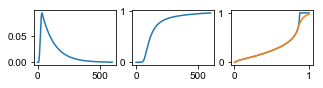

In [6]:
from prediction_functions import *

# constants
constants = get_constants(constants)
experiment_time = 600 # number of seconds

fig = plt.figure()
fig.set_figwidth(5)
fig.set_figheight(1)

# VELOCITY
dead_volume = 0.35 #mL
injection_duration = Injection_volume/Injection_rate*60 #s
velocity_peak = 0.1 #cm/s from Schlieren measurements
mean_free_path = np.sqrt(10)*12200e-6 #m NOT AT ALL SURE; MFP probably closer to 63nm
time_range = np.linspace(0,experiment_time,601)

velocity = calculate_velocity_profile(time_range, Injection_start_t, injection_duration, velocity_peak, constants["kinematic viscosity"], mean_free_path)
fig.add_subplot(131)
plt.plot(velocity);


# CONVECTION-DIFFUSION
x_range = np.linspace(0,sensor_separation_distance*1e-2 , 41)
y_width = 3.5 #cm

concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, Injection_volume, y_width)
fig.add_subplot(132)
plt.plot(time,concentration);


# ADSORPTION
adsorption_isotherm_model = "ISF_4" # can be ISF_2, FHH, or ISF_4
h_range = np.linspace(0,sensor_pore_radius*10e-10 *1.05, 500)
isotherm_terminal_slope = 5
isotherm_correction = "exponential"

params = {"Pentane": [47.9e6, 3.38e-10, 59.5e6, 0.69e-10, 8.70, 1.79] # DBdB theory Pi1[Pa], lambda1[m], Pi2[Pa], lambda2[m]; FHH theory k,m (unitless)
         } # [2*47.9e6, .5*3.38e-10, .2*59.5e6, .5*0.69e-10, 8.70, 1.79]

isotherm_h, isotherm_P, critical_thickness  = calculate_partial_pressure_adsorption(h_range, sensor_pore_radius*1e-9, adsorption_isotherm_model, params[adsorption_parameters_for], constants)
isotherm_h_corrected, isotherm_P_corrected = apply_correction_to_isotherm(isotherm_P, isotherm_h, "exponential", isotherm_terminal_slope)

fig.add_subplot(133)
plt.plot(isotherm_P, isotherm_h);
plt.plot(isotherm_P_corrected, isotherm_h_corrected);

/Applications/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1298: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/Applications/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1303: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


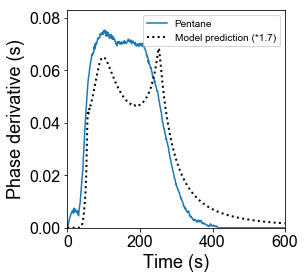

In [7]:
# Interpolate adsorption isotherm
from scipy.interpolate import interp1d
isotherm_film_height = interp1d(isotherm_P_corrected, isotherm_h_corrected)

# Calculate adsorbed film thickness
film_height = isotherm_film_height(concentration*1)
film_height[np.isnan(film_height)] = 0

# Calculate height gradient, smooth and normalize
height_deriv = np.gradient(film_height)
height_deriv = scipy.signal.savgol_filter(height_deriv, window_length=31, polyorder=2)
height_deriv = height_deriv/np.sqrt(np.sum(height_deriv**2))


from plot_functions import plot_deriv
plot_deriv(constants['experiment comparison'], labels = None, norm = True, ax = None, color = None);
plt.plot(time,height_deriv*1.7,':',linewidth=2,c='k')

plt.xlabel('Time (s)', fontsize = 18)
plt.ylabel('Phase derivative (s)', fontsize = 18)
plt.tick_params(labelsize= 16)
plt.legend(['Pentane','Model prediction (*1.7)'])

#plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/Theory comparison - Pentane.svg', dpi=1200)

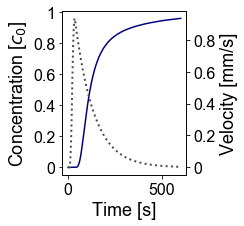

In [8]:
plt.plot(time,concentration,c=(0,0,0.5));
plt.xlabel('Time [s]',fontsize = 18)
plt.ylabel('Concentration [$c_0$]',fontsize = 18)
plt.tick_params(labelsize=16)
plt.gca().set_yticks([0,0.2,0.4,0.6,0.8,1])
plt.gca().set_yticklabels([0,0.2,0.4,0.6,0.8,1])
ax = plt.twinx()
ax.plot(np.linspace(0,600,velocity.size),velocity,':',linewidth=2,c=[0.3,0.3,0.3]);
ax.set_ylabel('Velocity [mm/s]', fontsize=18)
ax.tick_params(labelsize=16)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8])

plt.gcf().set_size_inches(3.5,3.25)
plt.tight_layout()
#plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/Convection profile.svg', dpi=1200)

## B) Static data - total shift

In [9]:
import sys
import pandas as pd
from scipy.interpolate import interp1d

def load_TS(exp_set):
    folder = '../fra_exp_csv'

    # prepare dictionaries to reference data
    peak_shifts = {}
    peak_num_chem = {}

    # start toolbar
    sys.stdout.write("Loading experimental data \n")
    sys.stdout.flush()
    loaded = 0

    for count, chem in enumerate(exp_set):
        nums = exp_set[chem]

        #loads image then normalizes data
        datas = []
        wavelengths = []
        for b, num in enumerate(nums):
            data = pd.read_csv(folder + "/%06d.csv" % (num)) # load data from file
            data_spectra = (data.values[:,1:]-np.min(data.values[:,1:])).transpose()
            datas.append(data_spectra)
            wavelengths.append((data.values[:,:1]).transpose()[0])

            # update the bar
            sys.stdout.write('\r')
            bar = ((b+1)*100)/len(nums)
            # the exact output you're looking for:
            sys.stdout.write(str(chem) + ": [%-20s] %d%%" % ('='*int(bar/5-1) + str(int(bar % 10)), bar))
            sys.stdout.flush()
            loaded += 1

        peak_shift = []
        for da in datas:
            # performing manually: phase_derivs = [da.getPhaseDerivative('spectral',1,smoothing=True,normalize=False) for da in datas]
            # Step 1: get phase derivative data at each time step
            ft_data = np.fft.fft(da)
            # Step 2: Calculates the phase
            R = np.real(ft_data[:, 1])
            I = np.imag(ft_data[:, 1])
            phi = I / (R ** 2 + I ** 2) ** 0.5
            # Step 3: Calculate phase derivative and perform smoothing with default parameters
            phi = scipy.signal.savgol_filter(phi, window_length=31, polyorder=2)

            peak_shift.append(phi[-1] - phi[0])

        #saves the derivs in the dictionary
        for n,num in enumerate(nums):
            peak_shifts[num] = peak_shift[n]
            peak_num_chem[num] = chem

        # update the bar
        sys.stdout.write("   " + str(count+1) + "/" + str(len(exp_set)) + " complete\n")
        sys.stdout.flush()

    print("Length of experimental set loaded: " + str(loaded))
    
    return peak_shifts, peak_num_chem, loaded


def sort_by_set_without_normalizing(exp_data, *sets):
    ''' Ex: train_derivs, train_lbl, test_derivs, test_lbl = sort_by_set(exp_derivs, exp_num_name, train_set, test_set) '''
    # create empty dictionaries
    sorted_dataset = []
    for dataset in sets:
        derivs = []
        labels = []

        for chem, set_numbers in dataset.items():
            for num in set_numbers:
                derivs.append(exp_data[num])
                labels.append(chem)

        sorted_dataset.append(np.array(derivs).reshape(-1, 1))
        sorted_dataset.append(np.array(labels))
        
    return sorted_dataset


def plot_static_data(data, num_lbl, order, ax = None):
    if ax == None:
        fig,ax = plt.subplots()
        
    ref_indices = {'Pentane':1.358, 'Hexane':1.376, 'Heptane':1.388, 'Octane':1.398, 'Nonane':1.406, 'Decane':1.412, 'Ethanol':1.36, 'Water':1.333, 'Acetone':1.36, 'Toluene':1.497, 'Acetonitrile':1.344} #Alkanes - https://pubs.acs.org/doi/abs/10.1021/je00017a032; others - https://www.engineeringtoolbox.com/refractive-index-d_1264.html

    for i,chem in enumerate(order):
        ind = np.where(np.array(num_lbl.values()) == chem)[0]
        shifts = [data.values()[n] for n in ind]

        ax.plot(np.linspace(i,i,len(ind)),shifts,marker = 'o', label = chem)
        #plt.plot(np.linspace(ref_indices[chem],ref_indices[chem],len(ind)),shifts,marker = 'o', label = chem)
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=legendsize)
    ax.set_xticklabels(range(0,len(exp_set)))
    ax.set_xticklabels(exp_set.keys(), rotation=45, horizontalalignment='right', fontsize=ticksize);
    ax.set_ylim([0,1])

## C) Static data - reflectance change

In [10]:
import sys
import pandas as pd
from scipy.interpolate import interp1d

def load_RS(exp_set):
    folder = '../fra_exp_csv'

    # prepare dictionaries to reference data
    static_shifts = {}
    static_num_chem = {}

    # start toolbar
    sys.stdout.write("Loading experimental data \n")
    sys.stdout.flush()
    loaded = 0

    for count, chem in enumerate(exp_set):
        nums = exp_set[chem]

        #loads image then normalizes data
        datas = []
        wavelengths = []
        for b, num in enumerate(nums):
            data = pd.read_csv(folder + "/%06d.csv" % (num)) # load data from file
            data_spectra = (data.values[:,1:]-np.min(data.values[:,1:])).transpose()
            datas.append(data_spectra)
            wavelengths.append((data.values[:,:1]).transpose()[0])

            # update the bar
            sys.stdout.write('\r')
            bar = ((b+1)*100)/len(nums)
            # the exact output you're looking for:
            sys.stdout.write(str(chem) + ": [%-20s] %d%%" % ('='*int(bar/5-1) + str(int(bar % 10)), bar))
            sys.stdout.flush()
            loaded += 1

        static_shift = []
        for n,da in enumerate(datas):
            # Step 1: get shift between first and last spectrum
            Reflectance_shift = da[0]-da[-1]
            # Step 2: Smooth data #moved latee: and normalize the spectrum
            Reflectance_shift = scipy.signal.savgol_filter(Reflectance_shift, window_length=31, polyorder=2)
            #Reflectance_shift = Reflectance_shift/np.sqrt(np.sum(Reflectance_shift**2)) #moved to later
            # Step 3: Interpolate spectrum to 600-dimensional array
            Reflectance_shift_interp = interp1d(wavelengths[n], Reflectance_shift)

            static_shift.append(Reflectance_shift_interp(np.linspace(401,799,600)))

        #saves the derivs in the dictionary
        for n,num in enumerate(nums):
            static_shifts[num] = static_shift[n]
            static_num_chem[num] = chem

        # update the bar
        sys.stdout.write("   " + str(count+1) + "/" + str(len(exp_set)) + " complete\n")
        sys.stdout.flush()

    print("Length of experimental set loaded: " + str(loaded))
    
    return static_shifts, static_num_chem, loaded

# Load data

In [11]:
from datasets import original_SVC_set, pure_compounds_in_tall_cuvettes, train_test_split
exp_set = pure_compounds_in_tall_cuvettes() # original_SVC_set()
train_set, test_set = train_test_split(exp_set)

In [12]:
from data_functions import load_set_from_CSV
from datasets import sort_by_set

# Load temporal data (A)
PD_data, PD_num_name, _ = load_set_from_CSV(exp_set)
PD_train, train_lbl, PD_test, test_lbl = sort_by_set(PD_data, train_set, test_set)

# Load static total shift (B)
TS_data, TS_num_chem, _ = load_TS(exp_set)
TS_train, _, TS_test, _ = sort_by_set_without_normalizing(TS_data, train_set, test_set)

# Load static reflectance shift data (C)
RS_data, RS_num_chem, _ = load_RS(exp_set)
RS_train, _, RS_test, _ = sort_by_set(RS_data, train_set, test_set)

Loading experimental data 
Pentane: [===================0] 100%   1/11 complete
Hexane: [===================0] 100%   2/11 complete
Heptane: [===================0] 100%   3/11 complete
Octane: [===================0] 100%   4/11 complete
Nonane: [===================0] 100%   5/11 complete
Decane: [===================0] 100%   6/11 complete
Ethanol: [===================0] 100%   7/11 complete
Water: [===================0] 100%   8/11 complete
Acetone: [===================0] 100%   9/11 complete
Toluene: [===================0] 100%   10/11 complete
Acetonitrile: [===================0] 100%   11/11 complete
Length of experimental set loaded: 76
Loading experimental data 
Pentane: [===================0] 100%   1/11 complete
Hexane: [===================0] 100%   2/11 complete
Heptane: [===================0] 100%   3/11 complete
Octane: [===================0] 100%   4/11 complete
Nonane: [===================0] 100%   5/11 complete
Decane: [===================0] 100%   6/11 complete
Ethanol: [

# Figure

Classification

In [13]:
from sklearn import datasets, svm, metrics

SVC = {}

# train SVCs
SVC['PD'] = train_SVC(PD_train, train_lbl, C = 1e1, gamma = 1e1)
SVC['TS'] = train_SVC(TS_train, train_lbl, C = 1e0, gamma = 1e1)
SVC['RS'] = train_SVC(RS_train, train_lbl, C = 1e2, gamma = 1e0)

print("----- STATIC PD -----")
predict(SVC['PD'], PD_test, test_lbl);

print("----- STATIC TS -----")
predict(SVC['TS'], TS_test, test_lbl);

print("----- STATIC RS -----")
predict(SVC['RS'], RS_test, test_lbl);

Training accuracy: 0.98 (50)
Training accuracy: 0.22 (50)
Training accuracy: 0.66 (50)
----- STATIC PD -----
Validation accuracy: 0.885 (23/26)
Accuracy: 0.885
Precision: 0.894
F1 Score: 0.885
----- STATIC TS -----
Validation accuracy: 0.231 (6/26)
Accuracy: 0.231
Precision: 0.182
F1 Score: 0.091
----- STATIC RS -----
Validation accuracy: 0.423 (11/26)
Accuracy: 0.423
Precision: 0.394
F1 Score: 0.324


/Applications/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/Applications/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Applications/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Heptane is not in Exerimental isotherms.csv
Loading experimental data 
Heptane: [===================0] 100%   1/1 complete
Length of experimental set loaded: 3
Calculated average from 3 experiments.


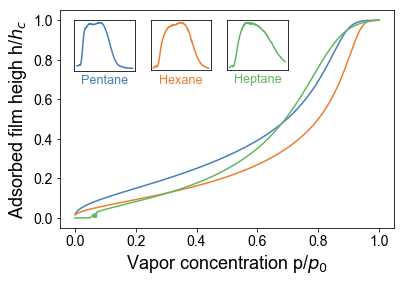

In [12]:
fig=plot_adsorption(['Pentane','Hexane','Heptane'], exp_set, PD_data, color_dict = color_dict, ax = None)
ax = plt.gca()

bb_data = Bbox.from_bounds(0.25, 0.75, 0.2, 0.25)
disp_coords = ax.transData.transform(bb_data)
fig_pos = fig.transFigure.inverted().transform(disp_coords)
pos = Bbox(fig_pos)

Heptane is not in Exerimental isotherms.csv
Loading experimental data 
Heptane: [===================0] 100%   1/1 complete
Length of experimental set loaded: 3
Calculated average from 3 experiments.


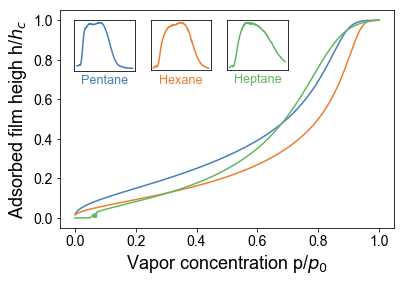

In [13]:
fig=plot_adsorption(['Pentane','Hexane','Heptane'], exp_set, PD_data, color_dict = color_dict, ax = None)
#fig.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/Figure-2 b-iii.svg', format='svg', dpi=1200)

Acetone is not in Exerimental isotherms.csv
Loading experimental data 
Acetone: [===================0] 100%   1/1 complete
Length of experimental set loaded: 8
Calculated average from 8 experiments.
Water is not in Exerimental isotherms.csv
Loading experimental data 
Water: [===================0] 100%   1/1 complete
Length of experimental set loaded: 7
Calculated average from 7 experiments.


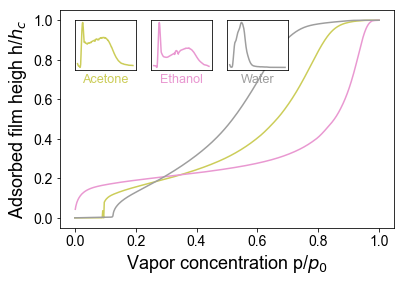

In [14]:
fig=plot_adsorption(['Acetone','Ethanol','Water'], exp_set, PD_data, color_dict = color_dict, ax = None)
#fig.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/Figure-2 b-iv.svg', format='svg', dpi=1200)

## final

/Applications/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


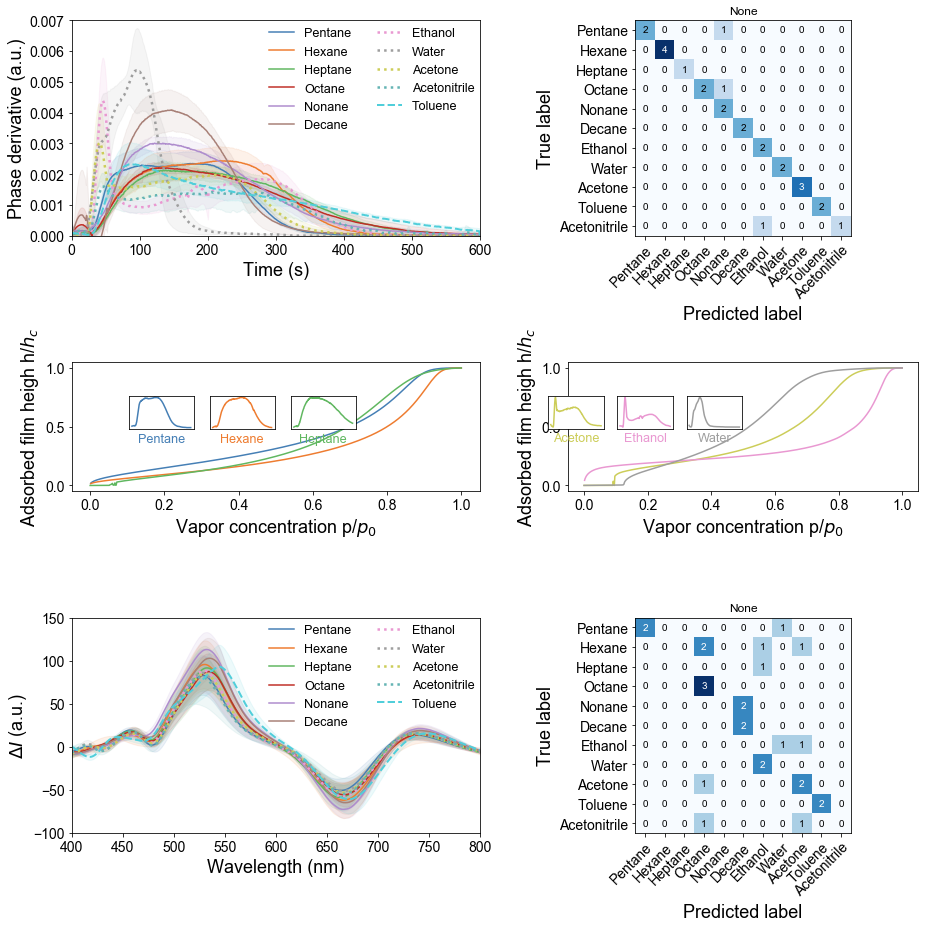

In [15]:
from datasets import color_dict
from matplotlib import gridspec
widths = [7, 6]
heights = [5, 3, 5]

grid = gridspec.GridSpec(nrows = len(heights), ncols = len(widths), width_ratios=widths, height_ratios=heights)

fig = plt.figure(figsize=(sum(widths),sum(heights)))

# Add axes which can span multiple grid boxes
ax = {}
ax['A1'] = fig.add_subplot(grid[0, 0])
ax['A2'] = fig.add_subplot(grid[0, 1])
ax['B1'] = fig.add_subplot(grid[1, 0])
ax['B2'] = fig.add_subplot(grid[1, 1])
ax['C1'] = fig.add_subplot(grid[2, 0])
ax['C2'] = fig.add_subplot(grid[2, 1])

from IPython.utils import io
# A-i: plot phase derivatives
subset = OrderedDict(exp_set.items()[0:6])
plot_array_data(subset, PD_data, [0,600], ylim=[0,0.005], color_dict = color_dict, ax=ax['A1'])
subset = OrderedDict(exp_set.items()[6:-2] + [exp_set.items()[-1]])
plot_array_data(subset, PD_data, [0,600], ylim=[0,0.007], color_dict = color_dict, ax=ax['A1'], linestyle = ':', linewidth = 2.5)
subset = OrderedDict([exp_set.items()[-2]])
plot_array_data(subset, PD_data, [0,600], ylim=[0,0.007], color_dict = color_dict, ax=ax['A1'], linestyle = '--', linewidth = 2)
#plot_array_data(exp_set, PD_data, [0,600], ylim=[0,0.007], color_dict = color_dict, ax=ax['A'])
ax['A1'].legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False, fontsize=legendsize*0.9)

# A-ii: plot confusion matrix
with io.capture_output() as captured:
    plot_confusion_matrix(test_lbl, predict(SVC['PD'], PD_test, test_lbl), classes=exp_set.keys(), ax=ax['A2']);

# B-i,ii: plot adsorption isotherms
with io.capture_output() as captured:
    plot_adsorption(['Pentane','Hexane','Heptane'], exp_set, PD_data, color_dict = color_dict, ax = ax['B1'])
    plot_adsorption(['Acetone','Ethanol','Water'], exp_set, PD_data, color_dict = color_dict, ax = ax['B2'])


# C-i: plot reflectance shifts
subset = OrderedDict(exp_set.items()[0:6])
plot_array_data(subset, RS_data, [400,800], ylim=[-100,150], color_dict = color_dict, ax=ax['C1'])
subset = OrderedDict(exp_set.items()[6:-2] + [exp_set.items()[-1]])
plot_array_data(subset, RS_data, [400,800], ylim=[-100,150], color_dict = color_dict, ax=ax['C1'], linestyle = ':', linewidth = 2.5)
subset = OrderedDict([exp_set.items()[-2]])
plot_array_data(subset, RS_data, [400,800], ylim=[-100,150], color_dict = color_dict, ax=ax['C1'], linestyle = '--', linewidth = 2)
#plot_array_data(exp_set, RS_data, [400,800], ylim=[-100,150], ax=ax['D1'])
ax['C1'].legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False, fontsize=legendsize*0.9)

#C-ii: plot confusion matrix
with io.capture_output() as captured:
    plot_confusion_matrix(test_lbl, predict(SVC['RS'], RS_test, test_lbl), classes=exp_set.keys(), ax=ax['C2']);

plt.tight_layout()
#fig.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/Figure-2 JN.svg', format='svg', dpi=1200)

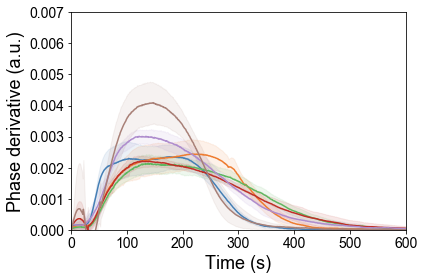

In [27]:
fig,ax = plt.subplots()

subset = OrderedDict(exp_set.items()[0:6])
plot_array_data(subset, PD_data, [0,600], ylim=[0,0.007], color_dict = color_dict, ax=ax)
#subset = OrderedDict(exp_set.items()[6:-2] + [exp_set.items()[-1]])
#plot_array_data(subset, PD_data, [0,600], ylim=[0,0.007], color_dict = color_dict, ax=ax, linestyle = ':', linewidth = 2.5)
#subset = OrderedDict([exp_set.items()[-2]])
#plot_array_data(subset, PD_data, [0,600], ylim=[0,0.007], color_dict = color_dict, ax=ax, linestyle = '--', linewidth = 2)
l = plt.legend()
l.remove()
#plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/Alkanes only.svg', dpi=300, bbox_inches='tight')

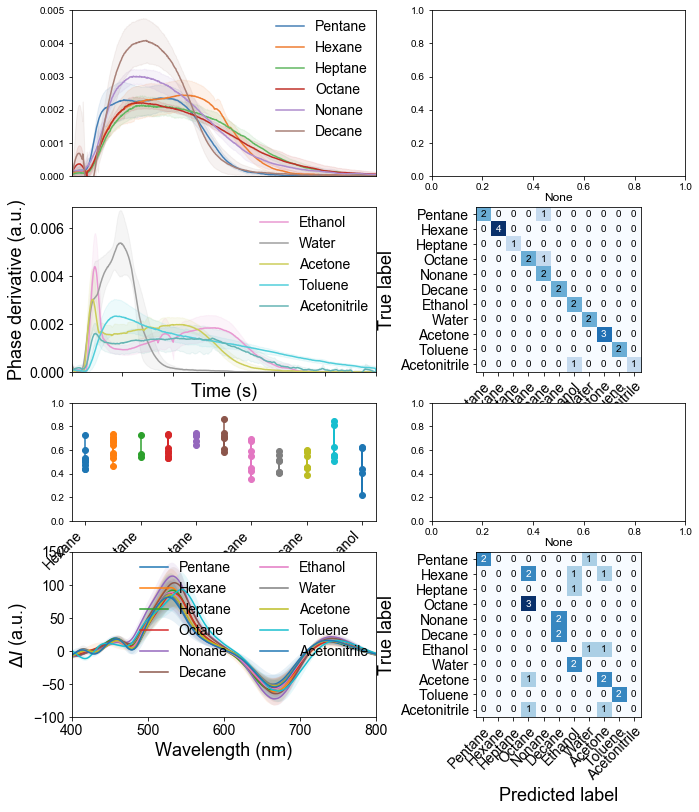

In [16]:
from datasets import color_dict
from matplotlib import gridspec
widths = [6, 5]
heights = [3.5, 3.5, 2.5, 3.5]

grid = gridspec.GridSpec(nrows = len(heights), ncols = len(widths), width_ratios=widths, height_ratios=heights)

fig = plt.figure(figsize=(sum(widths),sum(heights)))

# Add axes which can span multiple grid boxes
ax = {}
ax['A1'] = fig.add_subplot(grid[0, 0])
ax['A2'] = fig.add_subplot(grid[1, 0], sharex = ax['A1'])
ax['A3'] = fig.add_subplot(grid[0, 1])
ax['A4'] = fig.add_subplot(grid[1, 1])
ax['B1'] = fig.add_subplot(grid[2, 0])
ax['B2'] = fig.add_subplot(grid[2, 1])
ax['C1'] = fig.add_subplot(grid[3, 0])
ax['C2'] = fig.add_subplot(grid[3, 1])


from IPython.utils import io
# A-i,ii: plot phase derivatives
subset = OrderedDict(exp_set.items()[0:6])
plot_array_data(subset, PD_data, [0,600], ylim=[0,0.005], color_dict = color_dict, ax=ax['A1'], label = False)
ax['A1'].set_xticklabels(())
ax['A1'].tick_params(bottom = False)
subset = OrderedDict(exp_set.items()[6:])
plot_array_data(subset, PD_data, [0,600], ylim=[0,0.0069], color_dict = color_dict, ax=ax['A2'])

# A-iii: plot adsorption isotherms

# A-iv: plot confusion matrix
with io.capture_output() as captured:
    plot_confusion_matrix(test_lbl, predict(SVC['PD'], PD_test, test_lbl), classes=exp_set.keys(), ax=ax['A4']);

# B-i: plot total shifts
plot_static_data(TS_data, TS_num_chem, exp_set.keys(), ax=ax['B1'])

# B-ii: plot prediction accuracy using total shift

# C-i: plot reflectance shifts
plot_array_data(exp_set, RS_data, [400,800], ylim=[-100,150], ax=ax['C1'])

# C-ii: plot confusion matrix
with io.capture_output() as captured:
    plot_confusion_matrix(test_lbl, predict(SVC['RS'], RS_test, test_lbl), classes=exp_set.keys(), ax=ax['C2']);


#plt.tight_layout()

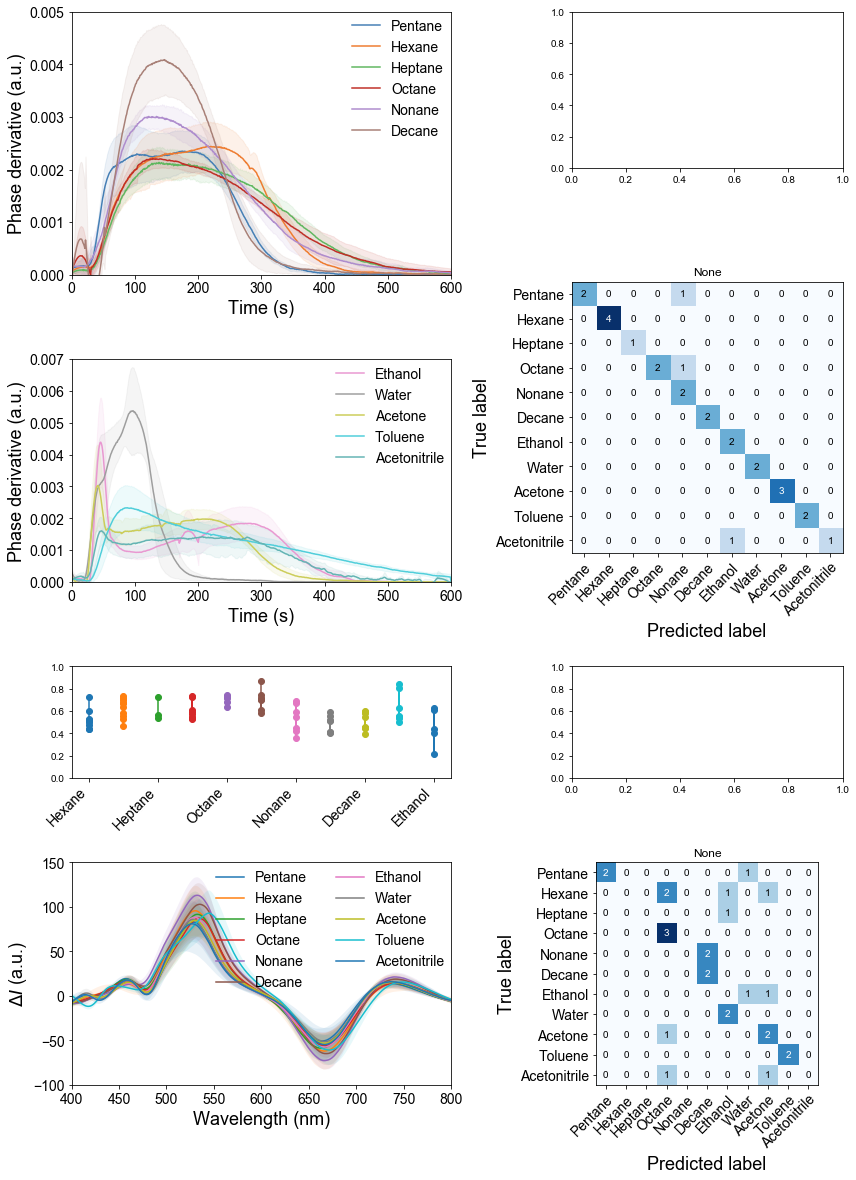

In [17]:
from datasets import color_dict
from matplotlib import gridspec
widths = [7, 5]
heights = [3.5, 0.5, 5, 2.5, 5]

grid = gridspec.GridSpec(nrows = len(heights), ncols = len(widths), width_ratios=widths, height_ratios=heights)

fig = plt.figure(figsize=(sum(widths)/1.,sum(heights)/1.))

# Add axes which can span multiple grid boxes
ax = {}
ax['A1'] = fig.add_subplot(grid[0:2, 0])
ax['A2'] = fig.add_subplot(grid[2, 0])
ax['A3'] = fig.add_subplot(grid[0, 1])
ax['A4'] = fig.add_subplot(grid[1:3, 1])
ax['B1'] = fig.add_subplot(grid[3, 0])
ax['B2'] = fig.add_subplot(grid[3, 1])
ax['C1'] = fig.add_subplot(grid[4, 0])
ax['C2'] = fig.add_subplot(grid[4, 1])


from IPython.utils import io
# A-i,ii: plot phase derivatives
subset = OrderedDict(exp_set.items()[0:6])
plot_array_data(subset, PD_data, [0,600], ylim=[0,0.005], color_dict = color_dict, ax=ax['A1'])
subset = OrderedDict(exp_set.items()[6:])
plot_array_data(subset, PD_data, [0,600], ylim=[0,0.007], color_dict = color_dict, ax=ax['A2'])

# A-iii: plot adsorption isotherms

# A-iv: plot confusion matrix
with io.capture_output() as captured:
    plot_confusion_matrix(test_lbl, predict(SVC['PD'], PD_test, test_lbl), classes=exp_set.keys(), ax=ax['A4']);

# B-i: plot total shifts
plot_static_data(TS_data, TS_num_chem, exp_set.keys(), ax=ax['B1'])

# B-ii: plot prediction accuracy using total shift

# C-i: plot reflectance shifts
plot_array_data(exp_set, RS_data, [400,800], ylim=[-100,150], ax=ax['C1'])

# C-ii: plot confusion matrix
with io.capture_output() as captured:
    plot_confusion_matrix(test_lbl, predict(SVC['RS'], RS_test, test_lbl), classes=exp_set.keys(), ax=ax['C2']);


plt.tight_layout()

Plot static data separately

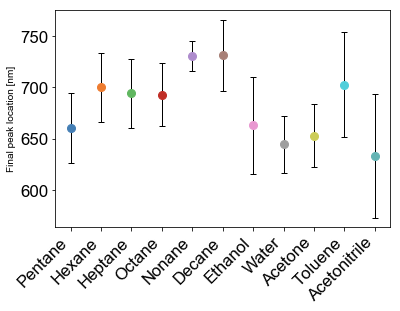

In [18]:
def plot_static_data2(data, num_lbl, order, ax = None):
    if ax == None:
        fig,ax = plt.subplots()
        
    ref_indices = {'Pentane':1.358, 'Hexane':1.376, 'Heptane':1.388, 'Octane':1.398, 'Nonane':1.406, 'Decane':1.412, 'Ethanol':1.36, 'Water':1.333, 'Acetone':1.36, 'Toluene':1.497, 'Acetonitrile':1.344} #Alkanes - https://pubs.acs.org/doi/abs/10.1021/je00017a032; others - https://www.engineeringtoolbox.com/refractive-index-d_1264.html

    for i,chem in enumerate(order):
        ind = np.where(np.array(num_lbl.values()) == chem)[0]
        shifts = [data.values()[n] for n in ind]
        avg = np.mean(shifts)*400+450
        std = np.std(shifts)*400

        ax.errorbar(i,avg,yerr=std,marker = 'o', markersize = 8, label = chem, c=color_dict[chem], ecolor = 'k', elinewidth = 1, capsize = 3)
        #plt.plot(np.linspace(ref_indices[chem],ref_indices[chem],len(ind)),shifts,marker = 'o', label = chem)
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=legendsize)
    ax.set_xticks(range(0,len(exp_set)))
    ax.set_xticklabels(exp_set.keys(), rotation=45, horizontalalignment='right', fontsize=ticksize*1.4);
    ax.tick_params(labelsize=ticksize*1.2)
    #ax.set_ylim([0,1])
    ax.set_ylabel('Final peak location [nm]')
    
plot_static_data2(TS_data, TS_num_chem, exp_set.keys())

In [19]:
from plot_functions import plot_confusion_matrix

from plot_functions import plot_my_learning_curve
dynamic_mean, dynamic_std, dynamic_M = plot_my_learning_curve(SVC, train_derivs+test_derivs, train_lbl+test_lbl);

NameError: name 'train_derivs' is not defined

Plots

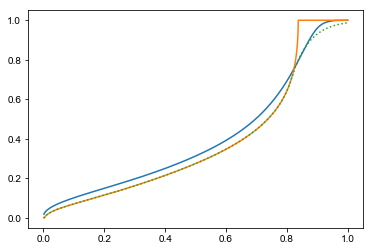

In [20]:
isotherm_film_height = get_isotherm_for(adsorption_parameters_for)

plt.plot(np.linspace(0,1,600),isotherm_film_height(np.linspace(0,max(isotherm_film_height.x),600)))
plt.plot(isotherm_P, isotherm_h);
plt.plot(isotherm_P_corrected, isotherm_h_corrected,':');

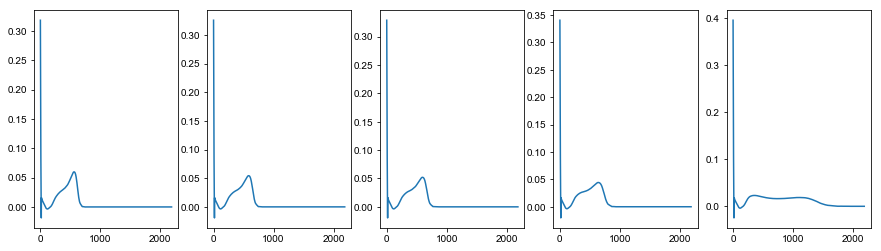

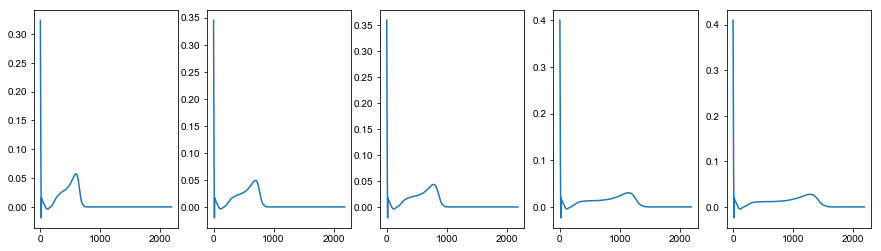

In [21]:
fig = plt.figure()
fig.set_figwidth(15)

# Concentration range
velocity = calculate_velocity_profile(time_range, Injection_start_t, injection_duration, velocity_peak, constants["kinematic viscosity"], mean_free_path)
isotherm_film_height = get_isotherm_for(adsorption_parameters_for)

def get_deriv(c):
    # Calculate adsorbed film thickness
    film_height = isotherm_film_height(c)
    film_height[np.isnan(film_height)] = 0

    # Calculate height gradient, smooth and normalize
    height_deriv = np.gradient(film_height)
    height_deriv = scipy.signal.savgol_filter(height_deriv, window_length=31, polyorder=2)
    height_deriv = height_deriv/np.sqrt(np.sum(height_deriv**2))
    return height_deriv

fig = plt.figure()
fig.set_figwidth(15)
#Max concentration range
concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, Injection_volume, y_width, sensor_separation_distance)

fig.add_subplot(151)
plt.plot(get_deriv(concentration))

fig.add_subplot(152)
plt.plot(get_deriv(concentration*0.965))

fig.add_subplot(153)
plt.plot(get_deriv(concentration*0.95))

fig.add_subplot(154)
plt.plot(get_deriv(concentration*0.9))

fig.add_subplot(155)
plt.plot(get_deriv(concentration*0.7))

# Injected volume range
fig = plt.figure()
fig.set_figwidth(15)
#1
concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, 1.0, y_width, sensor_separation_distance)

fig.add_subplot(151)
plt.plot(get_deriv(concentration))

#2
concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, 0.8, y_width, sensor_separation_distance)

fig.add_subplot(152)
plt.plot(get_deriv(concentration))

#3
concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, 0.6, y_width, sensor_separation_distance)

fig.add_subplot(153)
plt.plot(get_deriv(concentration))

#4
concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, 0.2, y_width, sensor_separation_distance)

fig.add_subplot(154)
plt.plot(get_deriv(concentration))

#5
concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, 0.01, y_width, sensor_separation_distance)

fig.add_subplot(155)
plt.plot(get_deriv(concentration))



In [22]:
add_isotherm_for('Ethanol')

Ethanol is already in isotherms. Remove before adding again.


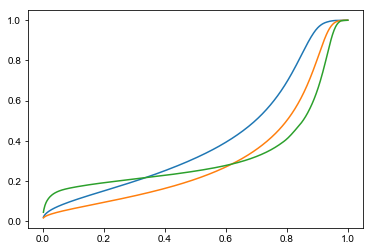

In [23]:
isotherm_film_height = get_isotherm_for('Pentane')
plt.plot(np.linspace(0,1,600),isotherm_film_height(np.linspace(0,max(isotherm_film_height.x),600)))
isotherm_film_height = get_isotherm_for('Hexane')
plt.plot(np.linspace(0,1,600),isotherm_film_height(np.linspace(0,max(isotherm_film_height.x),600)))
isotherm_film_height = get_isotherm_for('Ethanol')
plt.plot(np.linspace(0,1,600),isotherm_film_height(np.linspace(0,max(isotherm_film_height.x),600)))

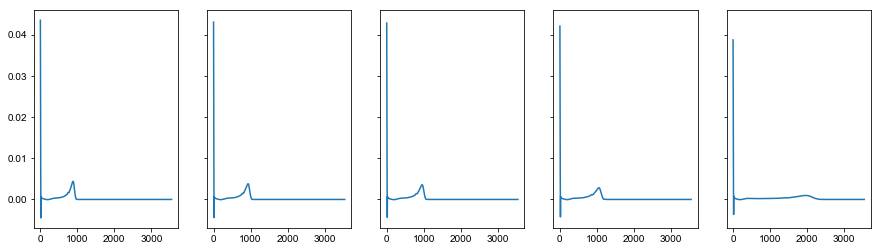

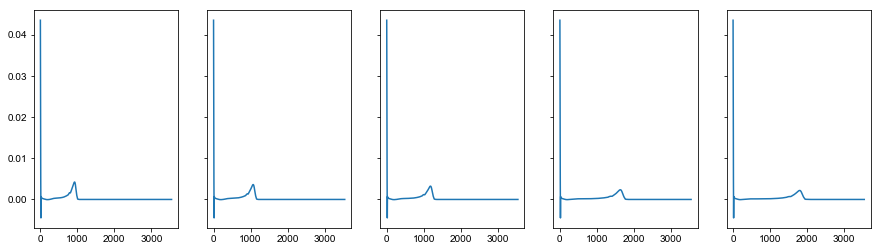

In [24]:
#ETHANOL
constants = "Ethanol"
adsorption_parameters_for = "Ethanol"

fig = plt.figure()
fig.set_figwidth(15)

constants = get_constants(constants)

# Concentration range
velocity = calculate_velocity_profile(time_range, Injection_start_t, injection_duration, velocity_peak, constants["kinematic viscosity"], mean_free_path)
isotherm_film_height = get_isotherm_for(adsorption_parameters_for)

def get_deriv(c):
    # Calculate adsorbed film thickness
    film_height = isotherm_film_height(c)
    film_height[np.isnan(film_height)] = 0

    # Calculate height gradient, smooth and normalize
    height_deriv = np.gradient(film_height)
    height_deriv = scipy.signal.savgol_filter(height_deriv, window_length=31, polyorder=2)
    #height_deriv = height_deriv/np.sqrt(np.sum(height_deriv**2))
    return height_deriv

fig, ax = plt.subplots(1, 5, sharex=True, sharey=True);
fig.set_figwidth(15)
#Max concentration range
concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, Injection_volume, y_width, sensor_separation_distance)

ax[0].plot(get_deriv(concentration))

ax[1].plot(get_deriv(concentration*0.965))

ax[2].plot(get_deriv(concentration*0.95))

ax[3].plot(get_deriv(concentration*0.9))

ax[4].plot(get_deriv(concentration*0.7))

# Injected volume range
fig, ax = plt.subplots(1, 5, sharex=True, sharey=True);
fig.set_figwidth(15)
#1
concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, 1.0, y_width, sensor_separation_distance)
ax[0].plot(get_deriv(concentration))

#2
concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, 0.8, y_width, sensor_separation_distance)
ax[1].plot(get_deriv(concentration))

#3
concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, 0.6, y_width, sensor_separation_distance)
ax[2].plot(get_deriv(concentration))

#4
concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, 0.2, y_width, sensor_separation_distance)
ax[3].plot(get_deriv(concentration))

#5
concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, 0.01, y_width, sensor_separation_distance)
ax[4].plot(get_deriv(concentration))

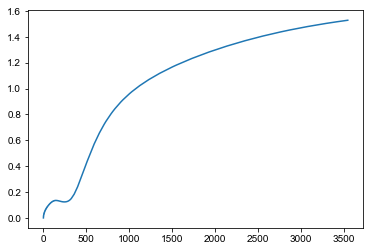

In [25]:
concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, 1.0, y_width, sensor_separation_distance)
plt.plot(concentration)

In [26]:
fig = plt.figure()
fig.set_figwidth(15)

from scipy.interpolate import interp1d

# Concentration range
velocity = calculate_velocity_profile(time_range, Injection_start_t, injection_duration, velocity_peak, constants["kinematic viscosity"], mean_free_path)
isotherm_h, isotherm_P, critical_thickness  = calculate_partial_pressure_adsorption(h_range, sensor_pore_radius*1e-9, adsorption_isotherm_model, params[adsorption_parameters_for], constants)
isotherm_h_corrected, isotherm_P_corrected = apply_correction_to_isotherm(isotherm_P, isotherm_h, "exponential", isotherm_terminal_slope)
isotherm_film_height = interp1d(isotherm_P_corrected, isotherm_h_corrected)

def get_deriv(c,film_height):
    # Calculate adsorbed film thickness
    film_height = film_height(c)
    film_height[np.isnan(film_height)] = 0

    # Calculate height gradient, smooth and normalize
    height_deriv = np.gradient(film_height)
    height_deriv = scipy.signal.savgol_filter(height_deriv, window_length=31, polyorder=2)
    height_deriv = height_deriv/np.sqrt(np.sum(height_deriv**2))
    return height_deriv

fig = plt.figure()
fig.set_figwidth(15)
#Max concentration range
concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, Injection_volume, y_width, sensor_separation_distance)

fig.add_subplot(151)
plt.plot(get_deriv(concentration,isotherm_film_height))

fig.add_subplot(152)
plt.plot(get_deriv(concentration*0.965,isotherm_film_height))

fig.add_subplot(153)
plt.plot(get_deriv(concentration*0.95,isotherm_film_height))

fig.add_subplot(154)
plt.plot(get_deriv(concentration*0.9,isotherm_film_height))

fig.add_subplot(155)
plt.plot(get_deriv(concentration*0.7,isotherm_film_height))

# Injected volume range
fig, ax = plt.subplots(1, 5, sharex=True, sharey=True);
fig.set_figwidth(15)
#1
isotherm_h, isotherm_P, critical_thickness  = calculate_partial_pressure_adsorption(h_range, sensor_pore_radius*1e-9, adsorption_isotherm_model, params[adsorption_parameters_for], constants)
isotherm_h_corrected, isotherm_P_corrected = apply_correction_to_isotherm(isotherm_P, isotherm_h, "exponential", isotherm_terminal_slope)
isotherm_film_height = interp1d(isotherm_P_corrected, isotherm_h_corrected)
ax[0].plot(get_deriv(concentration,isotherm_film_height))

#2
isotherm_h, isotherm_P, critical_thickness  = calculate_partial_pressure_adsorption(h_range, sensor_pore_radius*2e-9, adsorption_isotherm_model, params[adsorption_parameters_for], constants)
isotherm_h_corrected, isotherm_P_corrected = apply_correction_to_isotherm(isotherm_P, isotherm_h, "exponential", isotherm_terminal_slope)
isotherm_film_height = interp1d(isotherm_P_corrected, isotherm_h_corrected)
ax[1].plot(get_deriv(concentration,isotherm_film_height))

#3
isotherm_h, isotherm_P, critical_thickness  = calculate_partial_pressure_adsorption(h_range, sensor_pore_radius*3e-9, adsorption_isotherm_model, params[adsorption_parameters_for], constants)
isotherm_h_corrected, isotherm_P_corrected = apply_correction_to_isotherm(isotherm_P, isotherm_h, "exponential", isotherm_terminal_slope)
isotherm_film_height = interp1d(isotherm_P_corrected, isotherm_h_corrected)
ax[2].plot(get_deriv(concentration,isotherm_film_height))

#4
isotherm_h, isotherm_P, critical_thickness  = calculate_partial_pressure_adsorption(h_range, sensor_pore_radius*5e-9, adsorption_isotherm_model, params[adsorption_parameters_for], constants)
isotherm_h_corrected, isotherm_P_corrected = apply_correction_to_isotherm(isotherm_P, isotherm_h, "exponential", isotherm_terminal_slope)
isotherm_film_height = interp1d(isotherm_P_corrected, isotherm_h_corrected)
ax[3].plot(get_deriv(concentration,isotherm_film_height))

#5
isotherm_h, isotherm_P, critical_thickness  = calculate_partial_pressure_adsorption(h_range, sensor_pore_radius*10e-9, adsorption_isotherm_model, params[adsorption_parameters_for], constants)
isotherm_h_corrected, isotherm_P_corrected = apply_correction_to_isotherm(isotherm_P, isotherm_h, "exponential", isotherm_terminal_slope)
isotherm_film_height = interp1d(isotherm_P_corrected, isotherm_h_corrected)
ax[4].plot(get_deriv(concentration,isotherm_film_height))


KeyError: 'Ethanol'

# Testing

In [ ]:
SVM = train_SVC(PD_train, train_lbl, C = 1e1, gamma = 1e1, kernel='rbf')
predict(SVM, PD_test, test_lbl);

In [ ]:
SVM = train_SVC(PD_train, train_lbl, C = 1e3, gamma = 1e1, kernel='linear')
predict(SVM, PD_test, test_lbl);

In [ ]:
SVM.coef_.shape

In [ ]:
for n in range(0,55):
    plt.plot(SVM.coef_[n,:])

In [18]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier(SVC(C = 1e4, gamma = 1e1, kernel='linear')).fit(PD_train, train_lbl)
print clf.score(PD_train, train_lbl)
print clf.score(PD_test, test_lbl)

1.0
0.807692307692


In [19]:
clf.coef_.shape

(11, 600)

In [20]:
train_set

OrderedDict([('Pentane', [148, 174, 203, 239, 240, 435]),
             ('Hexane', [175, 184, 204, 205, 424, 425]),
             ('Heptane', [206, 207]),
             ('Octane', [151, 177, 208, 244, 283]),
             ('Nonane', [152, 189, 267]),
             ('Decane', [153, 179, 190, 197, 284]),
             ('Ethanol', [157, 324, 330, 440, 442]),
             ('Water', [169, 170, 312, 313, 444]),
             ('Acetone', [159, 160, 327, 437, 438]),
             ('Toluene', [154, 181, 446, 447, 449]),
             ('Acetonitrile', [164, 453, 454])])

In [21]:
test_lbl

['Pentane',
 'Pentane',
 'Pentane',
 'Hexane',
 'Hexane',
 'Hexane',
 'Hexane',
 'Heptane',
 'Octane',
 'Octane',
 'Octane',
 'Nonane',
 'Nonane',
 'Decane',
 'Decane',
 'Ethanol',
 'Ethanol',
 'Water',
 'Water',
 'Acetone',
 'Acetone',
 'Acetone',
 'Toluene',
 'Toluene',
 'Acetonitrile',
 'Acetonitrile']

In [22]:
PD_test[0].shape

(600,)

In [23]:
identity = OrderedDict()

for n,chem in enumerate(train_lbl):
    res = []
    for m in range(0,len(clf.coef_)):
        res.append(np.dot(clf.coef_[m,:],PD_train[n])+clf.intercept_[m])
    
    try:
        identity[chem].append(np.argmax(res))
    except:
        identity[chem] = [np.argmax(res)]

for chem in identity:
    identity[chem] = max(set(identity[chem]), key = identity[chem].count)

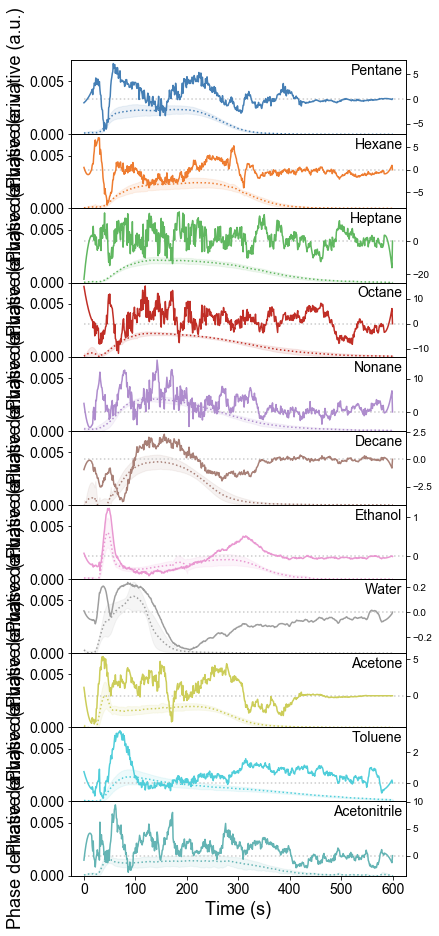

In [24]:
fig,ax = plt.subplots(ncols = 1, nrows = 11, sharex = True)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0)

for n,chem in enumerate(identity):
    subset = OrderedDict([exp_set.items()[n]])
    plot_array_data(subset, PD_data, [0,600], ylim=[0,0.007], color_dict = color_dict, ax=ax[n], linestyle = ':', linewidth = 1.5)
    ax[n].get_legend().remove()
    
    ax2 = ax[n].twinx()
    ax2.set_xlim([-25,625])
    ax2.plot([0,650],[0,0],color=(0.8,0.8,0.8),linestyle=':') # plot line zero
    ax2.plot(clf.coef_[identity[chem]], color=color_dict[chem])
    ax[n].text(0.99,0.95, chem, fontsize=14, verticalalignment='top', horizontalalignment = 'right', transform = ax[n].transAxes)

Plotting the product of the phase derivative and coef_

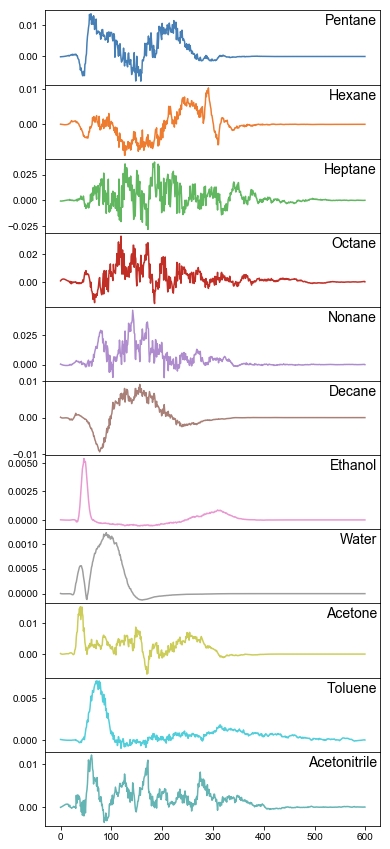

In [25]:
fig,ax = plt.subplots(ncols = 1, nrows = 11, sharex = True)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0)

for n,chem in enumerate(identity):
    subset = OrderedDict([exp_set.items()[n]])
    data = [PD_data[m] for m in subset.values()[0]]
    avg = np.average(data, axis = 0) # calculate average
    
    ax[n].plot(clf.coef_[identity[chem]]*avg, color=color_dict[chem])
    ax[n].text(0.99,0.95, chem, fontsize=14, verticalalignment='top', horizontalalignment = 'right', transform = ax[n].transAxes)

In [26]:
from datasets import *
TM40_set = pure_compounds(['Pentane','Hexane','Heptane','Octane','Nonane','Decane'], in_ = medium_Cuvettes(), with_ = SM30_Sensors(), and_a = injection_Time([15.0]), and_b = injection_Rate(6.0), and_c = injection_Volume([1.3]))
TM40_set

OrderedDict([('Pentane', [489]),
             ('Hexane', [295, 296, 487, 490]),
             ('Heptane', [481, 488]),
             ('Octane', [293, 294, 483, 485, 491, 492, 493, 497]),
             ('Nonane', [482, 494]),
             ('Decane', [291, 292, 484, 495, 496])])

In [27]:
TM40_data, TM40_num_name, _ = load_set_from_CSV(TM40_set)

Loading experimental data 
Pentane: [===================0] 100%   1/6 complete
Hexane: [===================0] 100%   2/6 complete
Heptane: [===================0] 100%   3/6 complete
Octane: [===================0] 100%   4/6 complete
Nonane: [===================0] 100%   5/6 complete
Decane: [===================0] 100%   6/6 complete
Length of experimental set loaded: 22


In [28]:
TM40_train_set, TM40_test_set = train_test_split(TM40_set)
TM40_train, TM40_train_lbl, TM40_test, TM40_test_lbl = sort_by_set(TM40_data, TM40_train_set, TM40_test_set)

Training accuracy: 0.9375 (16)
0.9375  (15 of 16)
0.833333333333  (5 of 6)


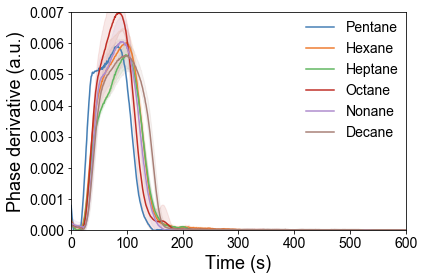

In [29]:
plot_array_data(TM40_set, TM40_data, [0,600], ylim=[0,0.007], color_dict = color_dict)
test_SVM = train_SVC(TM40_train, TM40_train_lbl, C = 1e1, gamma = 1e1)
print str(test_SVM.score(TM40_train, TM40_train_lbl)) + '  ('+str(int(test_SVM.score(TM40_train, TM40_train_lbl)*len(TM40_train_lbl)))+ ' of ' + str(len(TM40_train_lbl)) + ')'
print str(test_SVM.score(TM40_test, TM40_test_lbl)) + '  ('+str(int(test_SVM.score(TM40_test, TM40_test_lbl)*len(TM40_test_lbl)))+ ' of ' + str(len(TM40_test_lbl)) + ')'

(0, 250)

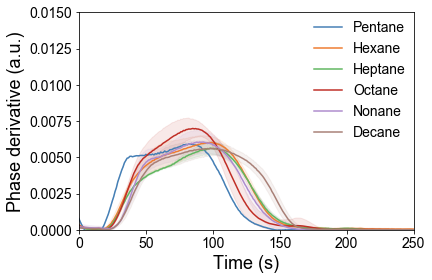

In [30]:
plot_array_data(TM40_set, TM40_data, [0,600], ylim=[0,0.015], color_dict = color_dict)
plt.xlim([0,250])

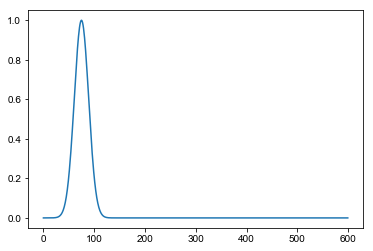

In [31]:
gauss = lambda m,x0,x: np.exp( -(x-x0)**2/(m*20)**2 )
plt.plot(gauss(1,75,np.linspace(0,600,600)))

[-26.19005666]   [-27.70970416]
[-37.12237643]   [-38.52240758]
[-1.81237886]   [-0.33020865]
[ 1.59877159]   [-0.47956948]
[-71.26117052]   [-50.08854762]
[-5.82365204]   [ 4.88316746]
[-72.97220336]   [-69.81486124]
[-29.08458884]   [-47.35608186]
[-24.10607747]   [-23.55646854]
[-10.31557995]   [-12.35750498]
[-0.30544067]   [-0.29247902]
Ethanol (4)


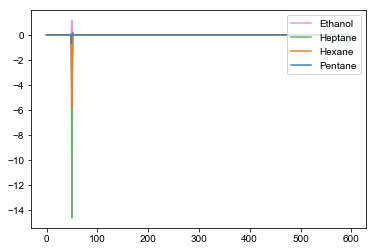

In [32]:
newdict = {value:key for key, value in identity.items()}
gauss = lambda m,x0,x: np.exp( -(x-x0)**2/(m*20)**2 )
lin = gauss(0.05,50,np.linspace(0,600,600))# np.linspace(0,0,600) #interpolation(np.linspace(0,250,600))

res=[]
for m in range(0,len(clf.coef_)):
    res.append(np.dot(clf.coef_[m,:],lin)+clf.intercept_[m])
    print str(np.dot(clf.coef_[m,:],lin)+clf.intercept_[m]) + '   ' + str(clf.intercept_[m])
    
    if newdict[m] in ['Pentane','Hexane','Heptane','Ethanol']:#,'Octane','Nonane','Decane']:
        plt.plot(clf.coef_[m,:]*lin,color=color_dict[newdict[m]],label=newdict[m])
plt.legend(loc='upper right')
print newdict[np.argmax(res)] + ' ('+str(np.argmax(res)+1)+')'

In [33]:
from scipy.interpolate import interp1d

for chem,values in TM40_set.items():
    for value in values:
        res = []
        for m in range(0,len(clf.coef_)):
            interpolation = interp1d(np.linspace(0,600,600), TM40_data[value], fill_value="extrapolate")
            res.append(np.dot(clf.coef_[m,:],interpolation(np.linspace(0,250,600)))+clf.intercept_[m])
        #print res
        print chem + ' ' + str(value) +': predicted as '+str(np.argmax(res))+ ' (' + str(identity[chem]) + ')'

Pentane 489: predicted as 5 (8)
Hexane 295: predicted as 5 (5)
Hexane 296: predicted as 5 (5)
Hexane 487: predicted as 5 (5)
Hexane 490: predicted as 5 (5)
Heptane 481: predicted as 5 (4)
Heptane 488: predicted as 5 (4)
Octane 293: predicted as 5 (7)
Octane 294: predicted as 5 (7)
Octane 483: predicted as 5 (7)
Octane 485: predicted as 5 (7)
Octane 491: predicted as 5 (7)
Octane 492: predicted as 5 (7)
Octane 493: predicted as 5 (7)
Octane 497: predicted as 5 (7)
Nonane 482: predicted as 5 (6)
Nonane 494: predicted as 5 (6)
Decane 291: predicted as 5 (2)
Decane 292: predicted as 5 (2)
Decane 484: predicted as 5 (2)
Decane 495: predicted as 5 (2)
Decane 496: predicted as 5 (2)


## Correlation functions

In [34]:
import numpy as np
import similaritymeasures
import matplotlib.pyplot as plt

In [35]:
x = np.linspace(1,1000,100)
y = np.linspace(1,100,100)
num_data = np.zeros((100, 2))
num_data[:, 0] = x
num_data[:, 1] = y

print similaritymeasures.frechet_dist(num_data, num_data)

0.0


Phase derivative data

In [36]:
sim = np.zeros((len(identity),len(identity)))
normalize = lambda x: x/np.sqrt(np.dot(x,x))

for n,chem in enumerate(identity):
    data = [PD_data[ind] for ind in exp_set[chem]]
    avg = np.average(data, axis = 0) # calculate average
    avg = normalize(avg)
    
    data_n = np.zeros((600,2))
    data_n[:,0] = avg
    data_n[:,1] = np.linspace(0,600,600)
    
    for m,chem in enumerate(identity):
        data2 = [PD_data[ind] for ind in exp_set[chem]]
        avg2 = np.average(data2, axis = 0) # calculate average
        avg2 = normalize(avg2)
        
        data_m = np.zeros((600,2))
        data_m[:,0] = avg2
        data_m[:,1] = np.linspace(0,600,600)
    
        sim[n,m] = round(similaritymeasures.area_between_two_curves(data_n, data_m),3)

In [37]:
#norm = np.amin(sim)
#sim_n = np.zeros(sim.shape)
#
#for n in range(sim.shape[0]):
#    for m in range(sim.shape[1]):
#        sim_n[n,m] = sim[n,m]/norm

In [38]:
table = []
for n,chem in enumerate(identity):
    row = [chem]
    for m in range(sim.shape[1]):
        row.append(sim[n,m])
    
    table.append(row)
    
from tabulate import tabulate
print(tabulate(table, headers=identity.keys()))

                Pentane    Hexane    Heptane    Octane    Nonane    Decane    Ethanol    Water    Acetone    Toluene    Acetonitrile
------------  ---------  --------  ---------  --------  --------  --------  ---------  -------  ---------  ---------  --------------
Pentane           0         5.922      7.533     6.359     3.898     4.163     11.233   12.599      4.327      8.375           7.981
Hexane            5.923     0          2.93      3.522     4.135     7.676      7.549   17.602      5.248      8.063           4.736
Heptane           7.533     2.93       0         1.651     4.52      9.06       7.903   19.008      7.043      5.644           3.517
Octane            6.36      3.522      1.652     0         3.295     7.887      8.695   18.109      6.806      5.173           4.165
Nonane            3.898     4.136      4.52      3.295     0         5.189      9.91    15.606      5.598      6.419           6.167
Decane            4.163     7.676      9.06      7.886     5.188     

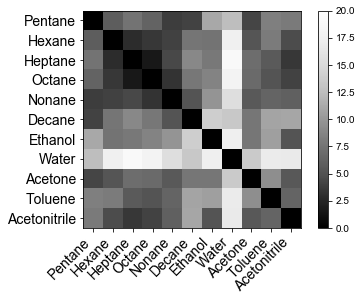

In [39]:
vmax = np.ceil(np.max(sim))

fig, ax = plt.subplots()
i = ax.imshow(sim, cmap=plt.cm.Greys, interpolation='nearest',vmin=0, vmax=vmax)
fig.colorbar(i)

ax.set_xticks(range(0,len(exp_set)))
ax.set_xticklabels(exp_set.keys(), rotation=45, horizontalalignment='right', fontsize=ticksize);
ax.set_yticks(range(0,len(exp_set)))
ax.set_yticklabels(exp_set.keys(), horizontalalignment='right', fontsize=ticksize);

plt.show()
#fig.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/PhaseDerivs similarity.svg', format='svg', dpi=1200)

Reflecance shift

In [40]:
sim2 = np.zeros((len(identity),len(identity)))
normalize = lambda x: x/np.sqrt(np.dot(x,x))

for n,chem in enumerate(identity):
    data = [RS_data[ind] for ind in exp_set[chem]]
    avg = np.average(data, axis = 0) # calculate average
    avg = normalize(avg)
    
    data_n = np.zeros((600,2))
    data_n[:,0] = avg
    data_n[:,1] = np.linspace(0,600,600)
    
    for m,chem in enumerate(identity):
        data2 = [RS_data[ind] for ind in exp_set[chem]]
        avg2 = np.average(data2, axis = 0) # calculate average
        avg2 = normalize(avg2)
        
        data_m = np.zeros((600,2))
        data_m[:,0] = avg2
        data_m[:,1] = np.linspace(0,600,600)
    
        sim2[n,m] = round(similaritymeasures.area_between_two_curves(data_n, data_m),3)

In [41]:
#norm = np.amin(sim)
#sim_n = np.zeros(sim.shape)
#
#for n in range(sim.shape[0]):
#    for m in range(sim.shape[1]):
#        sim_n[n,m] = sim[n,m]/norm

In [42]:
table = []
for n,chem in enumerate(identity):
    row = [chem]
    for m in range(sim2.shape[1]):
        row.append(sim2[n,m])
    
    table.append(row)
    
from tabulate import tabulate
print(tabulate(table, headers=identity.keys()))

                Pentane    Hexane    Heptane    Octane    Nonane    Decane    Ethanol    Water    Acetone    Toluene    Acetonitrile
------------  ---------  --------  ---------  --------  --------  --------  ---------  -------  ---------  ---------  --------------
Pentane           0         2.06       1.74      2.644     3.204     3.511      1.355    1.452      1.619      6.568           1.59
Hexane            2.06      0          1.684     1.533     1.889     2.043      1.218    2.39       1.483      4.833           2.277
Heptane           1.74      1.684      0         1.462     2.292     2.316      1.864    2.709      1.793      5.379           2.726
Octane            2.644     1.533      1.462     0         1.775     1.235      2.251    2.624      1.68       4.239           2.806
Nonane            3.204     1.889      2.292     1.775     0         1.218      2.244    2.624      1.846      4.094           2.966
Decane            3.511     2.043      2.316     1.235     1.218     0

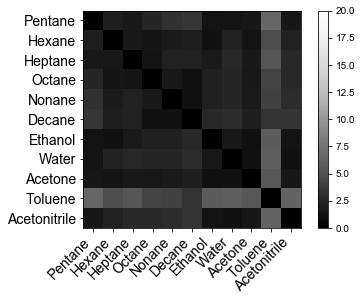

In [43]:
fig, ax = plt.subplots()
i = ax.imshow(sim2, cmap=plt.cm.Greys, interpolation='nearest',vmin=0, vmax=vmax)
fig.colorbar(i)

ax.set_xticks(range(0,len(exp_set)))
ax.set_xticklabels(exp_set.keys(), rotation=45, horizontalalignment='right', fontsize=ticksize);
ax.set_yticks(range(0,len(exp_set)))
ax.set_yticklabels(exp_set.keys(), horizontalalignment='right', fontsize=ticksize);

plt.show()
#fig.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/ReflShifts.svg', format='svg', dpi=1200)

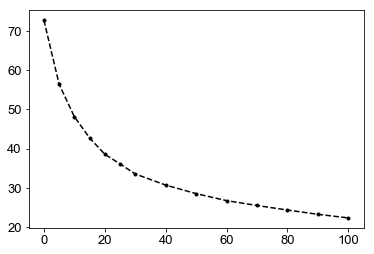

In [44]:
c = [0, 5, 10,15,20,25,30,40,50,60,70,80,90,100] # values from https://pubs.acs.org/doi/pdf/10.1021/je00019a016
g =  [72.75, 56.41, 48.14, 42.72, 38.56, 36.09, 33.53, 30.69, 28.51, 26.72, 25.48, 24.32, 23.23, 22.31]

plt.plot(c,g,'k.--')
plt.gca().tick_params(labelsize=13)